In [ ]:
import requests
from Bio import AlignIO, Phylo, SeqIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceMatrix
from Bio.Phylo import TreeConstruction
import matplotlib.pyplot as plt
import os
import subprocess
import urllib.parse




In [262]:
import esm
import torch 
import numpy as np
from scipy.spatial.distance import pdist, squareform
import torch.nn as nn

In [221]:
esm_model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
esm_model.eval()
batch_converter = alphabet.get_batch_converter()

In [ ]:
def fetch_uniprot_sequences(keyword, max_sequences=50):

    encoded_keyword = urllib.parse.quote(keyword)

    url = f"https://rest.uniprot.org/uniprotkb/search?query={encoded_keyword}&format=fasta&size={max_sequences}"

    print(f"Fetching from URL: {url}")
    response = requests.get(url)

    if response.status_code == 200:
        if len(response.text.strip()) == 0:
            raise ValueError("No sequences found in the response")

        file_name = "output.fasta"

        current_dir = os.getcwd()
        file_path = os.path.join(current_dir, file_name)
        with open(file_path, mode='w') as fasta_file:
            fasta_file.write(response.text)
            return fasta_file.name
    else:
        print(f"HTTP Status Code: {response.status_code}")
        print(f"Response content: {response.text[:200]}") 
        raise ValueError(f"Failed to fetch sequences: Status code {response.status_code}")

def obtain_fasta_file(keyword, title):

    print(f"Downloading sequences for {keyword}...")
    fasta_file = fetch_uniprot_sequences(keyword)
    original_sequences_file = f"{title.replace(' ', '_')}_sequences.fasta"
    with open(fasta_file, 'r') as source:
        with open(original_sequences_file, 'w') as dest:
            dest.write(source.read())

    sequences = list(SeqIO.parse(fasta_file, "fasta"))
    print(f"\nNumber of sequences downloaded: {len(sequences)}")


    print(f"\nOriginal sequences saved to: {original_sequences_file}")

    if len(sequences) < 3:
        print("Not enough sequences found for analysis")
        return
    
    return original_sequences_file

In [234]:
def obtain_protein_embeddings(fasta_file):
    sequences = []
    protein_names = []
    with open(fasta_file, "r") as file:
        for record in SeqIO.parse(file, "fasta"):
            sequences.append((record.id, str(record.seq)))
            protein_names.append(record.id.split('|')[-1])

    batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

    with torch.no_grad():
        results = esm_model(batch_tokens, repr_layers=[12]) 
        token_embeddings = results["representations"][12]

    embeddings = []
    for i, (_, seq) in enumerate(sequences):
        seq_len = len(seq)
        seq_embedding = token_embeddings[i, 1:seq_len + 1].mean(0) 
        embeddings.append(seq_embedding.numpy())
    
    return np.array(embeddings), protein_names

In [ ]:
def mafft_phylogeny_tree(input_fasta, output_fasta):
    cmd = ['mafft', '--auto', input_fasta]

    result = subprocess.run(cmd,
                            capture_output=True,
                            text=True,
                            check=True)

    with open(output_fasta, 'w') as handle:
        handle.write(result.stdout)

    mafft_alignment = AlignIO.read(output_fasta, "fasta")
    mafft_protein_names = []
    for record in mafft_alignment:
        mafft_protein_names.append(record.id.split('|')[-1])

    mafft_calculator = DistanceCalculator('blosum62')
    mafft_distance_matrix = mafft_calculator.get_distance(mafft_alignment)
    return np.array(mafft_distance_matrix), mafft_protein_names

def visualize_phylogeny_tree(distance_matrix, protein_names, method):
    lower_triangle_matrix = [
        [distance_matrix[i][j] for j in range(i + 1)]
        for i in range(len(distance_matrix))
    ]
    dm = DistanceMatrix(protein_names, lower_triangle_matrix)

    constructor = TreeConstruction.DistanceTreeConstructor()
    nj_tree = constructor.nj(dm)

    fig, ax = plt.subplots(figsize=(20, 30)) 
    Phylo.draw(nj_tree, axes=ax, do_show=False, branch_labels=lambda c: None) 
    ax.invert_yaxis() 
    plt.title(f"Ras Phylogeny Tree using {method}", fontsize=18, pad=20) 


    for clade in nj_tree.find_clades():
        clade.branch_length *= 1

    plt.show()

    tree_file = "esm_upgma_tree.newick"
    Phylo.write(nj_tree, tree_file, "newick")

    return nj_tree

In [ ]:
def clustal_phylogeny_tree(input_fasta, output_fasta):

    clustalomega_cline = ClustalOmegaCommandline(infile=input_fasta, outfile=output_fasta, seqtype="protein", verbose=True, force=True)
    stdout, stderr = clustalomega_cline()

    alignment = AlignIO.read(output_fasta, "fasta")
    clustal_protein_names = []
    for record in alignment:
        clustal_protein_names.append(record.id.split('|')[-1])
    calculator = DistanceCalculator('blosum62')
    distance_matrix = calculator.get_distance(alignment)
    return np.array(distance_matrix), clustal_protein_names

In [248]:
def compare_topology(tree1, tree2):
    
    def get_sorted_children(clade):
        if not clade.clades:
            return []
        children = [get_sorted_children(child) for child in clade.clades]
        return sorted(children, key=str)

    def compare_clades(clade1, clade2):
        if len(clade1.clades) != len(clade2.clades):
            return False
    
        sorted_children1 = get_sorted_children(clade1)
        sorted_children2 = get_sorted_children(clade2)
        return sorted_children1 == sorted_children2

    return compare_clades(tree1.root, tree2.root)


Fetching from URL: https://rest.uniprot.org/uniprotkb/search?query=gene%3ARAS%20AND%20reviewed%3Atrue&format=fasta&size=50

Number of sequences downloaded: 20

Original sequences saved to: Ras_Family_Tree_sequences.fasta


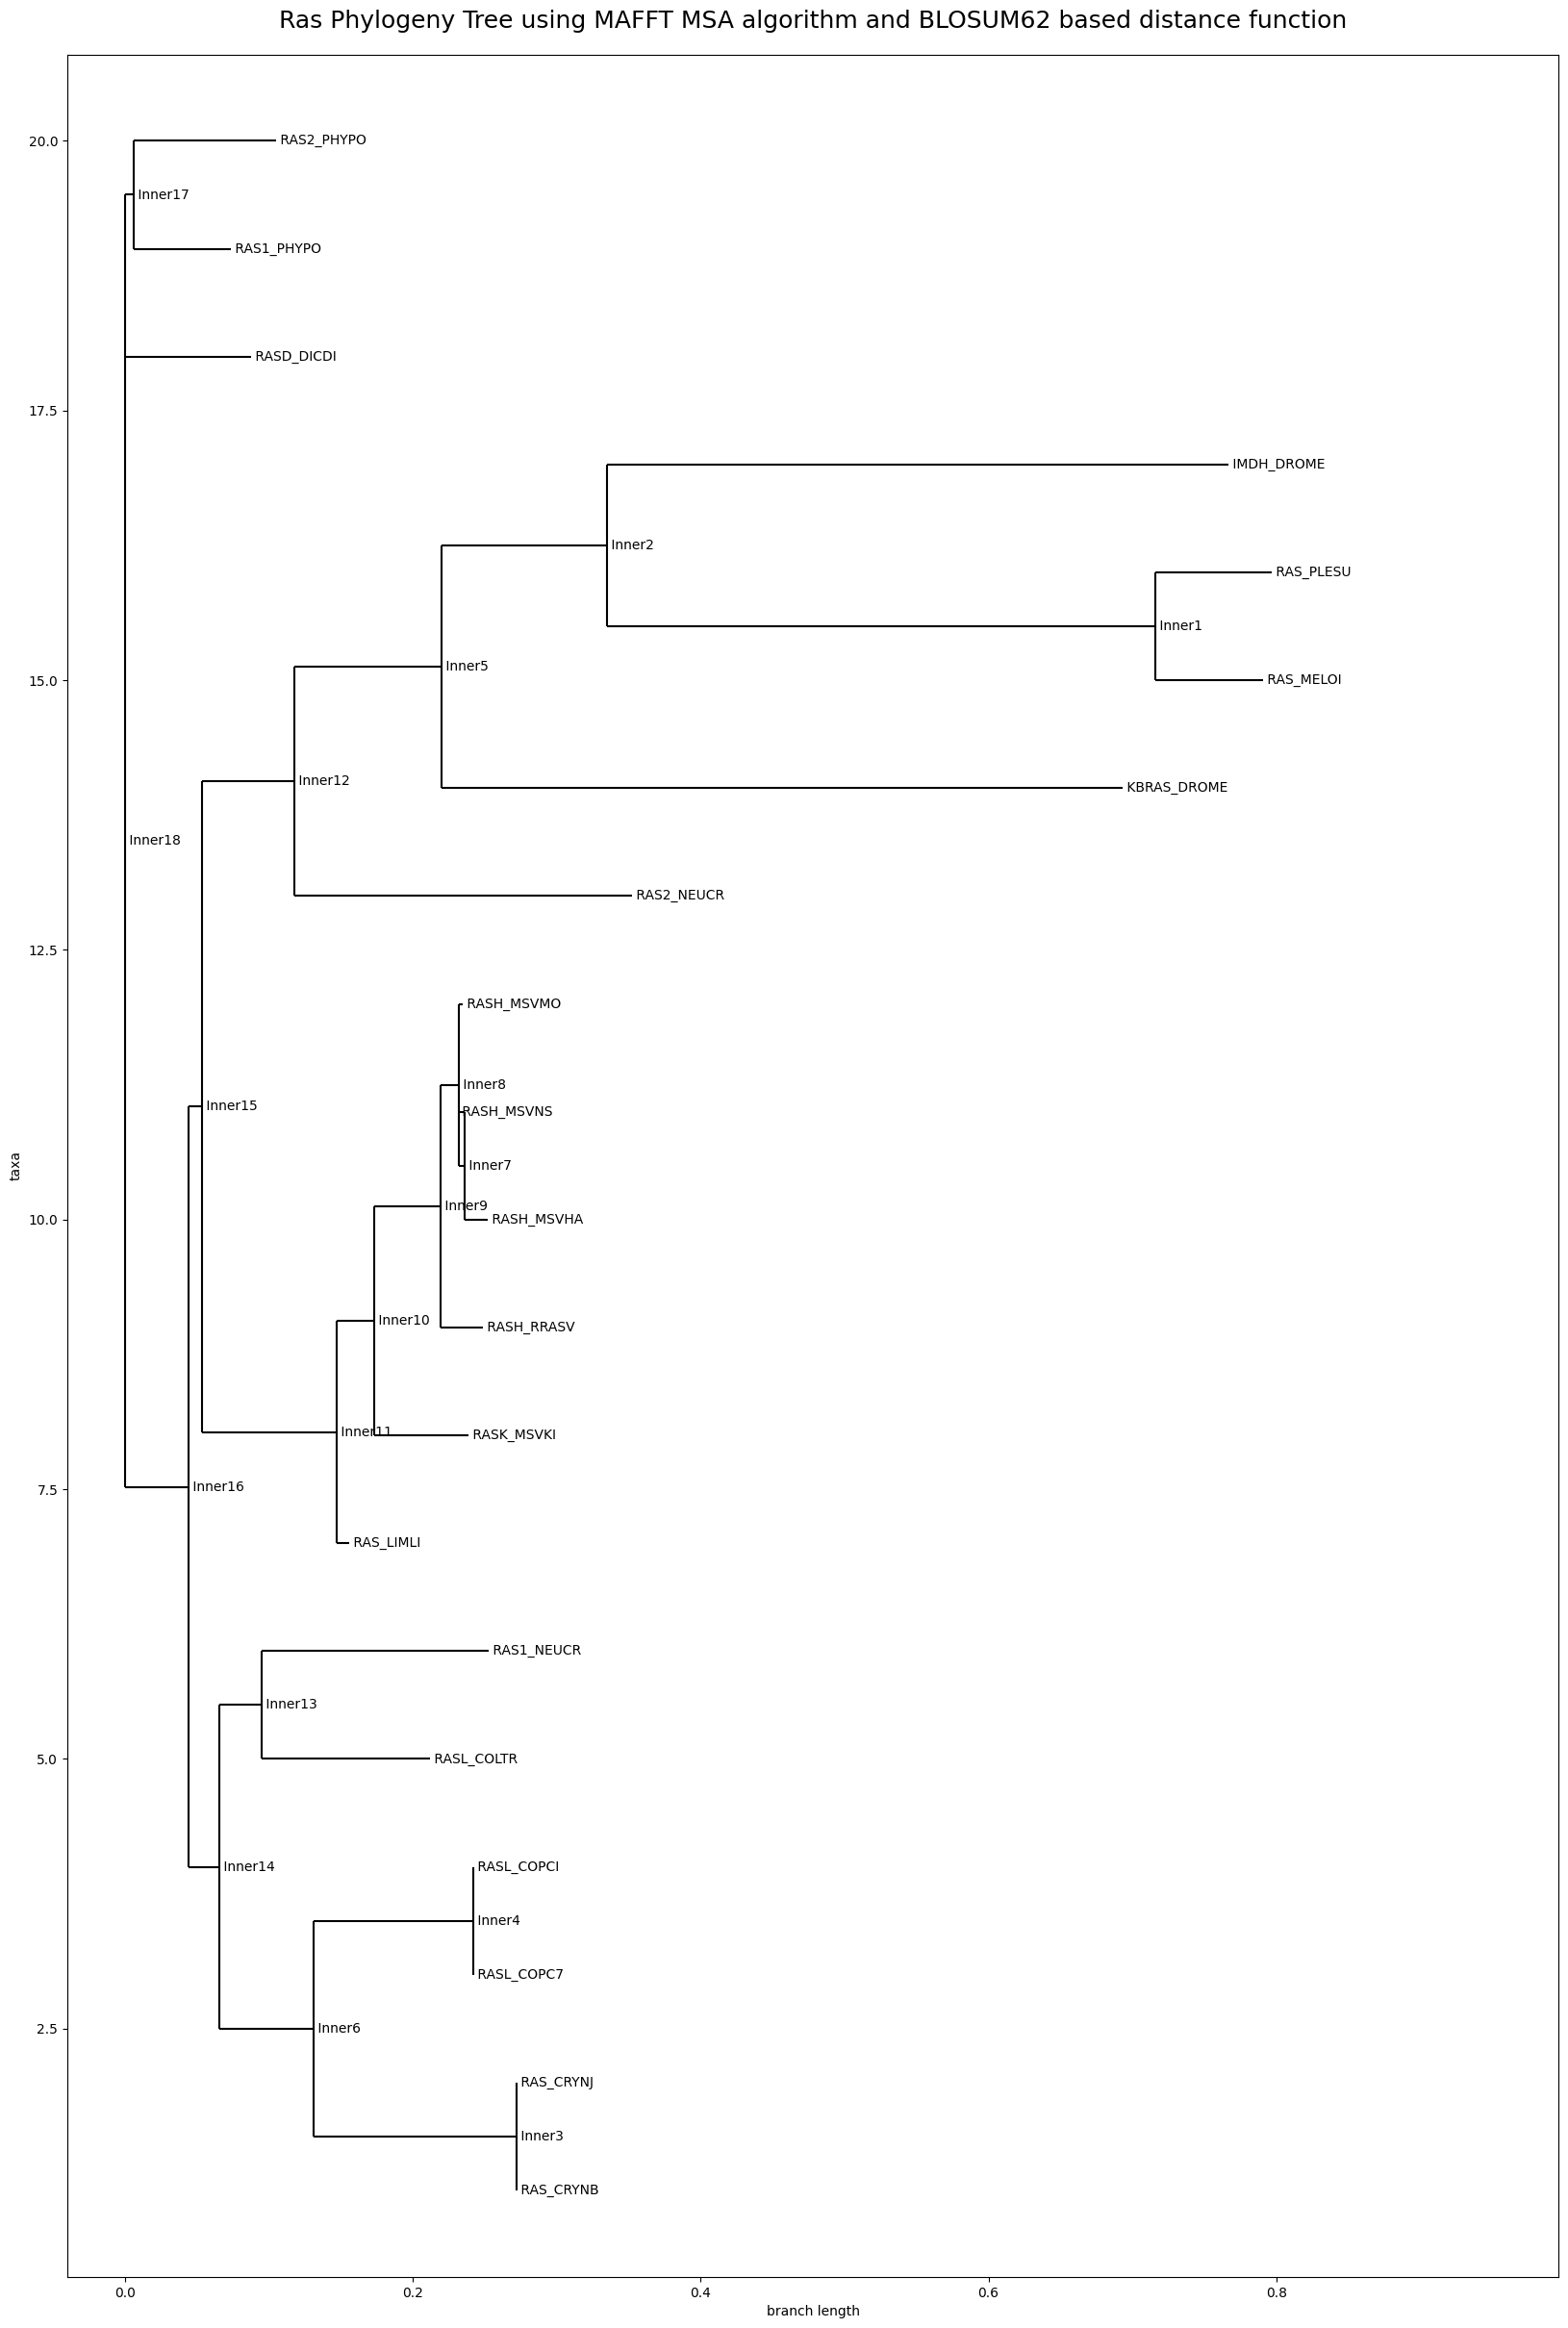

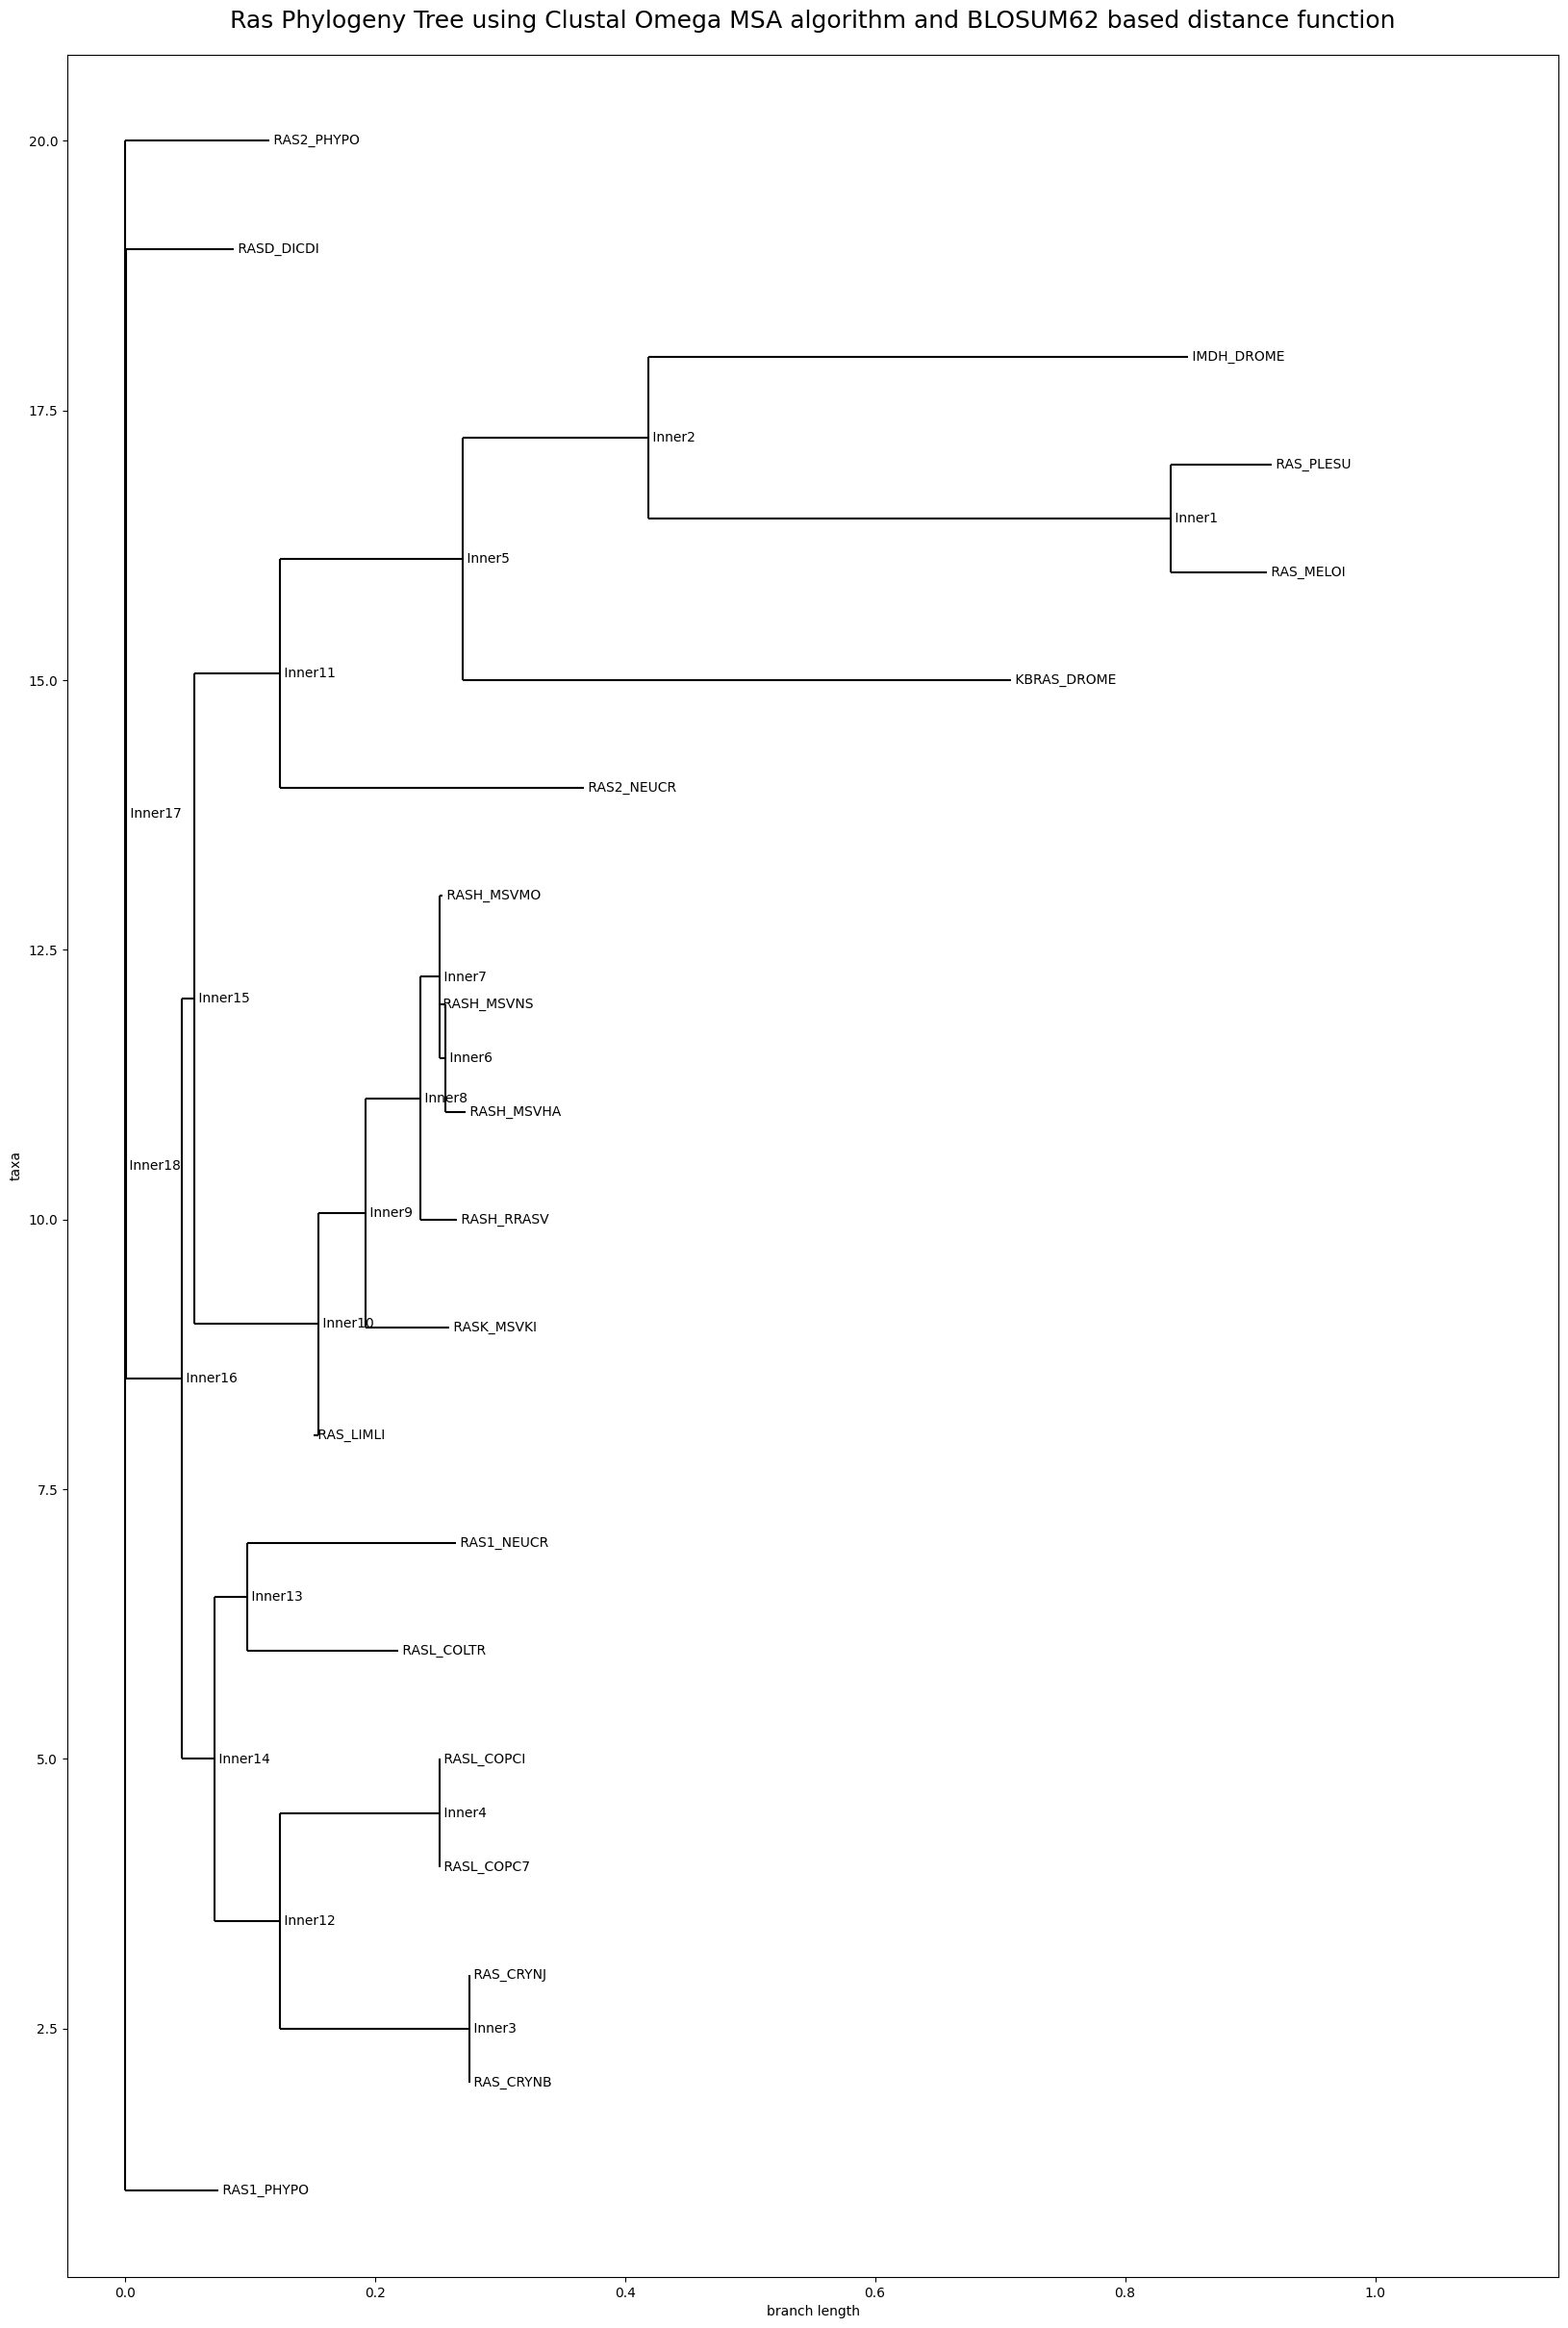

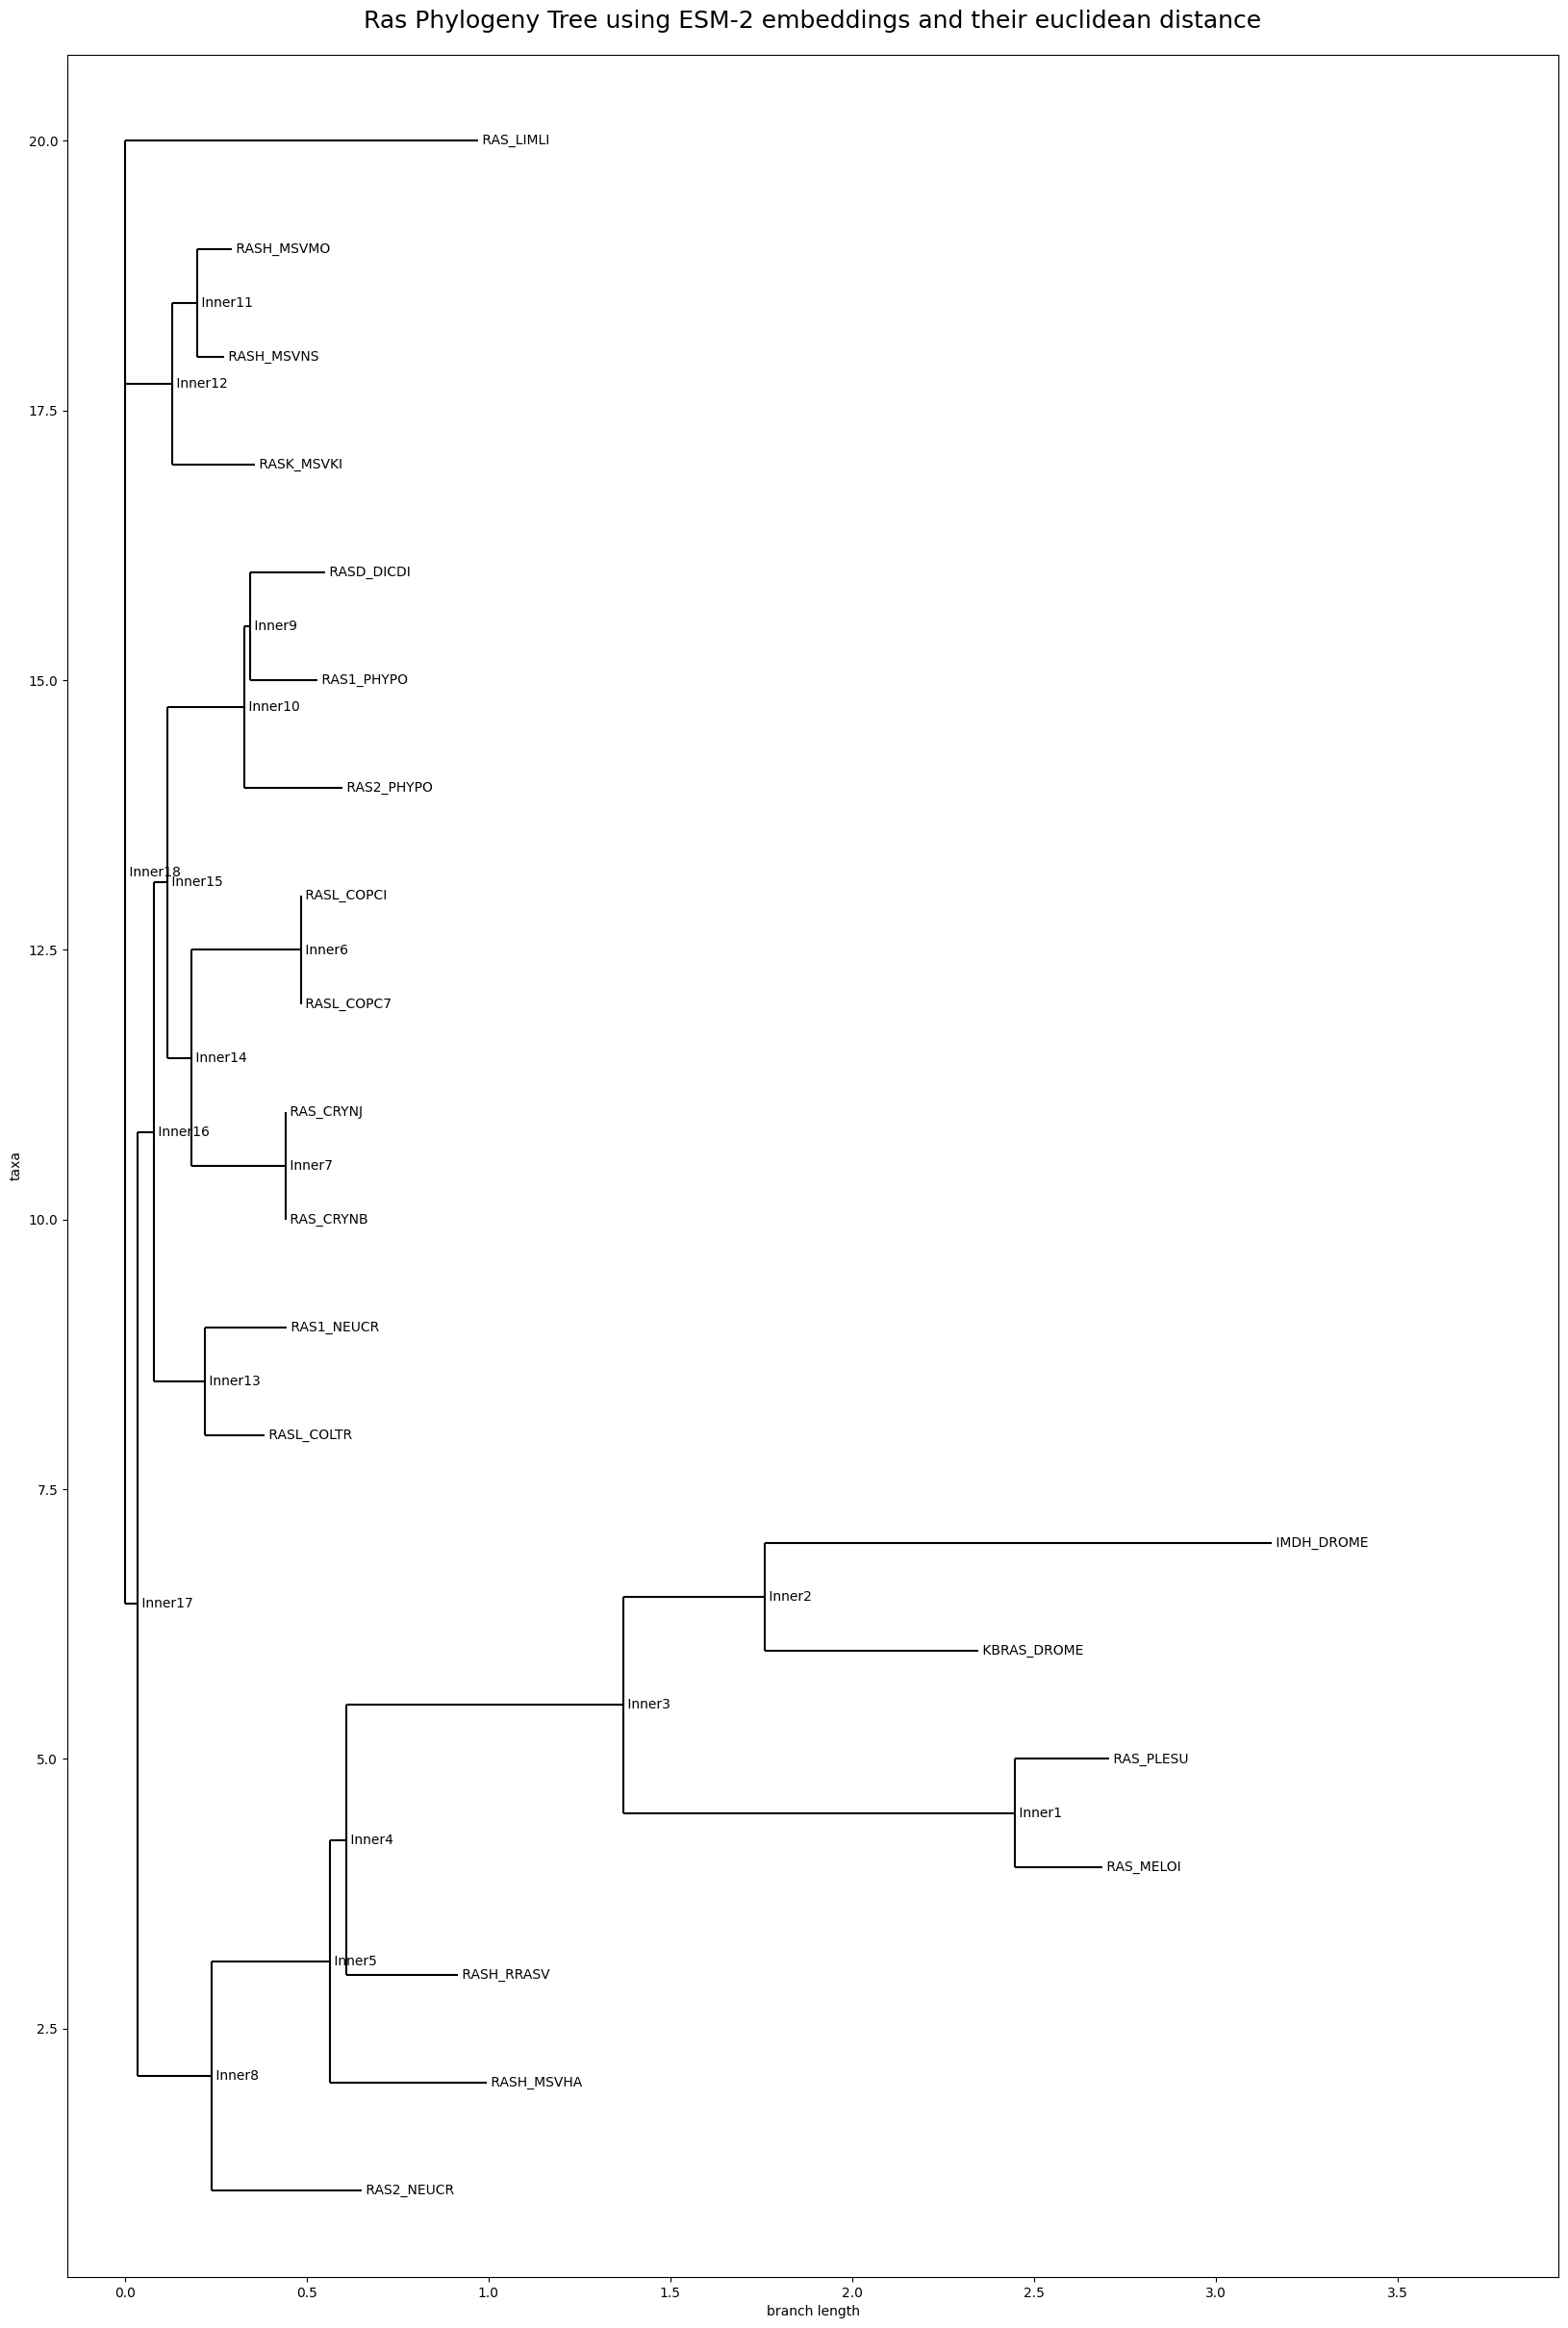

Frobenius norm between MAFFT distance matrix and Clustal Omega distance matrix: 1.193304349378105
Frobenius norm between MAFFT distance matrix and ESM distance matrix: 28.150134360872865
Frobenius norm between Clustal distance matrix and ESM distance matrix: 27.1612933655268
The topologies of MAFFT Tree and Clustal Tree differ.
The topologies of MAFFT Tree and ESM Tree differ.
The topologies of Clustal Tree and ESM Tree differ.


In [260]:
protein_families = [
    ("protein_name:globin AND reviewed:true", "Globin Family Tree"),
    ("protein_name:insulin receptor kinase AND reviewed:true", "Insulin Receptor Kinase Tree"),
    ("gene:RAS AND reviewed:true", "Ras Family Tree"),
    ("gene:TP53 AND reviewed:true", "p53 Tumor Suppressor Protein Tree")
]

keyword, title = protein_families[2]

fasta_file = obtain_fasta_file(keyword, title)

mafft_distance_matrix, mafft_protein_names = mafft_phylogeny_tree(fasta_file, "aligned_Ras_mafft.fasta")
nj_tree_mafft = visualize_phylogeny_tree(mafft_distance_matrix, mafft_protein_names, "MAFFT MSA algorithm and BLOSUM62 based distance function")

clustal_distance_matrix, clustal_protein_names = clustal_phylogeny_tree(fasta_file, "aligned_Ras_clustal.fasta")
nj_tree_clustal = visualize_phylogeny_tree(clustal_distance_matrix, clustal_protein_names, "Clustal Omega MSA algorithm and BLOSUM62 based distance function")

embeddings, protein_names = obtain_protein_embeddings(fasta_file)
euclidean_dist = squareform(pdist(embeddings, metric='euclidean'))

nj_tree_esm = visualize_phylogeny_tree(euclidean_dist, protein_names, "ESM-2 embeddings and their euclidean distance")


frobenius_norm = np.linalg.norm(mafft_distance_matrix - clustal_distance_matrix, 'fro')
print(f"Frobenius norm between MAFFT distance matrix and Clustal Omega distance matrix: {frobenius_norm}")

frobenius_norm = np.linalg.norm(mafft_distance_matrix - euclidean_dist, 'fro')
print(f"Frobenius norm between MAFFT distance matrix and ESM distance matrix: {frobenius_norm}")

frobenius_norm = np.linalg.norm(clustal_distance_matrix - euclidean_dist, 'fro')
print(f"Frobenius norm between Clustal distance matrix and ESM distance matrix: {frobenius_norm}")

if compare_topology(nj_tree_mafft, nj_tree_clustal):
    print("The topologies of MAFFT Tree and Clustal Tree are the same.")
else:
    print("The topologies of MAFFT Tree and Clustal Tree differ.")

if compare_topology(nj_tree_mafft, nj_tree_esm):
    print("The topologies of MAFFT Tree and ESM Tree are the same.")
else:
    print("The topologies of MAFFT Tree and ESM Tree differ.")

if compare_topology(nj_tree_mafft, nj_tree_esm):
    print("The topologies of Clustal Tree and ESM Tree are the same.")
else:
    print("The topologies of Clustal Tree and ESM Tree differ.")


In [ ]:
class LinearEmbeddingTransformer(nn.Module):
    def __init__(self, input_dim):
        super(LinearEmbeddingTransformer, self).__init__()
        self.fc1 = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return torch.relu(self.fc1(x))

input_dim = 480
model = LinearEmbeddingTransformer(input_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.L1Loss()


torch_embedding = torch.tensor(embeddings, dtype=torch.float32, requires_grad=True)
num_epochs = 3000
frobenius_norm_embedding = []
frobenius_norm_distance_matrix = []
for epoch in range(num_epochs):
   
    transformed_X = model(torch_embedding)
    dists_sq = torch.cdist(transformed_X, transformed_X, p=2)**2

    dists_sq.diagonal().zero_()

    euclidean_dist = torch.sqrt(dists_sq)

    if epoch % 200 == 0 or epoch == 0:
        frobenius_norm_embedding.append(np.linalg.norm(torch_embedding.detach().numpy() - transformed_X.detach().numpy(), 'fro'))
        frobenius_norm_distance_matrix.append(np.linalg.norm(clustal_distance_matrix - euclidean_dist.detach().numpy(), 'fro'))

    distance_tensor = torch.tensor(clustal_distance_matrix, dtype=torch.float32).flatten()

    loss = criterion(euclidean_dist.flatten(), distance_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")





Epoch [1/3000], Loss: 0.1487
Epoch [2/3000], Loss: 0.1474
Epoch [3/3000], Loss: 0.1461
Epoch [4/3000], Loss: 0.1449
Epoch [5/3000], Loss: 0.1436
Epoch [6/3000], Loss: 0.1424
Epoch [7/3000], Loss: 0.1411
Epoch [8/3000], Loss: 0.1399
Epoch [9/3000], Loss: 0.1387
Epoch [10/3000], Loss: 0.1376
Epoch [11/3000], Loss: 0.1365
Epoch [12/3000], Loss: 0.1354
Epoch [13/3000], Loss: 0.1343
Epoch [14/3000], Loss: 0.1332
Epoch [15/3000], Loss: 0.1321
Epoch [16/3000], Loss: 0.1310
Epoch [17/3000], Loss: 0.1300
Epoch [18/3000], Loss: 0.1290
Epoch [19/3000], Loss: 0.1281
Epoch [20/3000], Loss: 0.1271
Epoch [21/3000], Loss: 0.1263
Epoch [22/3000], Loss: 0.1255
Epoch [23/3000], Loss: 0.1246
Epoch [24/3000], Loss: 0.1239
Epoch [25/3000], Loss: 0.1232
Epoch [26/3000], Loss: 0.1225
Epoch [27/3000], Loss: 0.1219
Epoch [28/3000], Loss: 0.1212
Epoch [29/3000], Loss: 0.1204
Epoch [30/3000], Loss: 0.1197
Epoch [31/3000], Loss: 0.1190
Epoch [32/3000], Loss: 0.1183
Epoch [33/3000], Loss: 0.1176
Epoch [34/3000], Lo

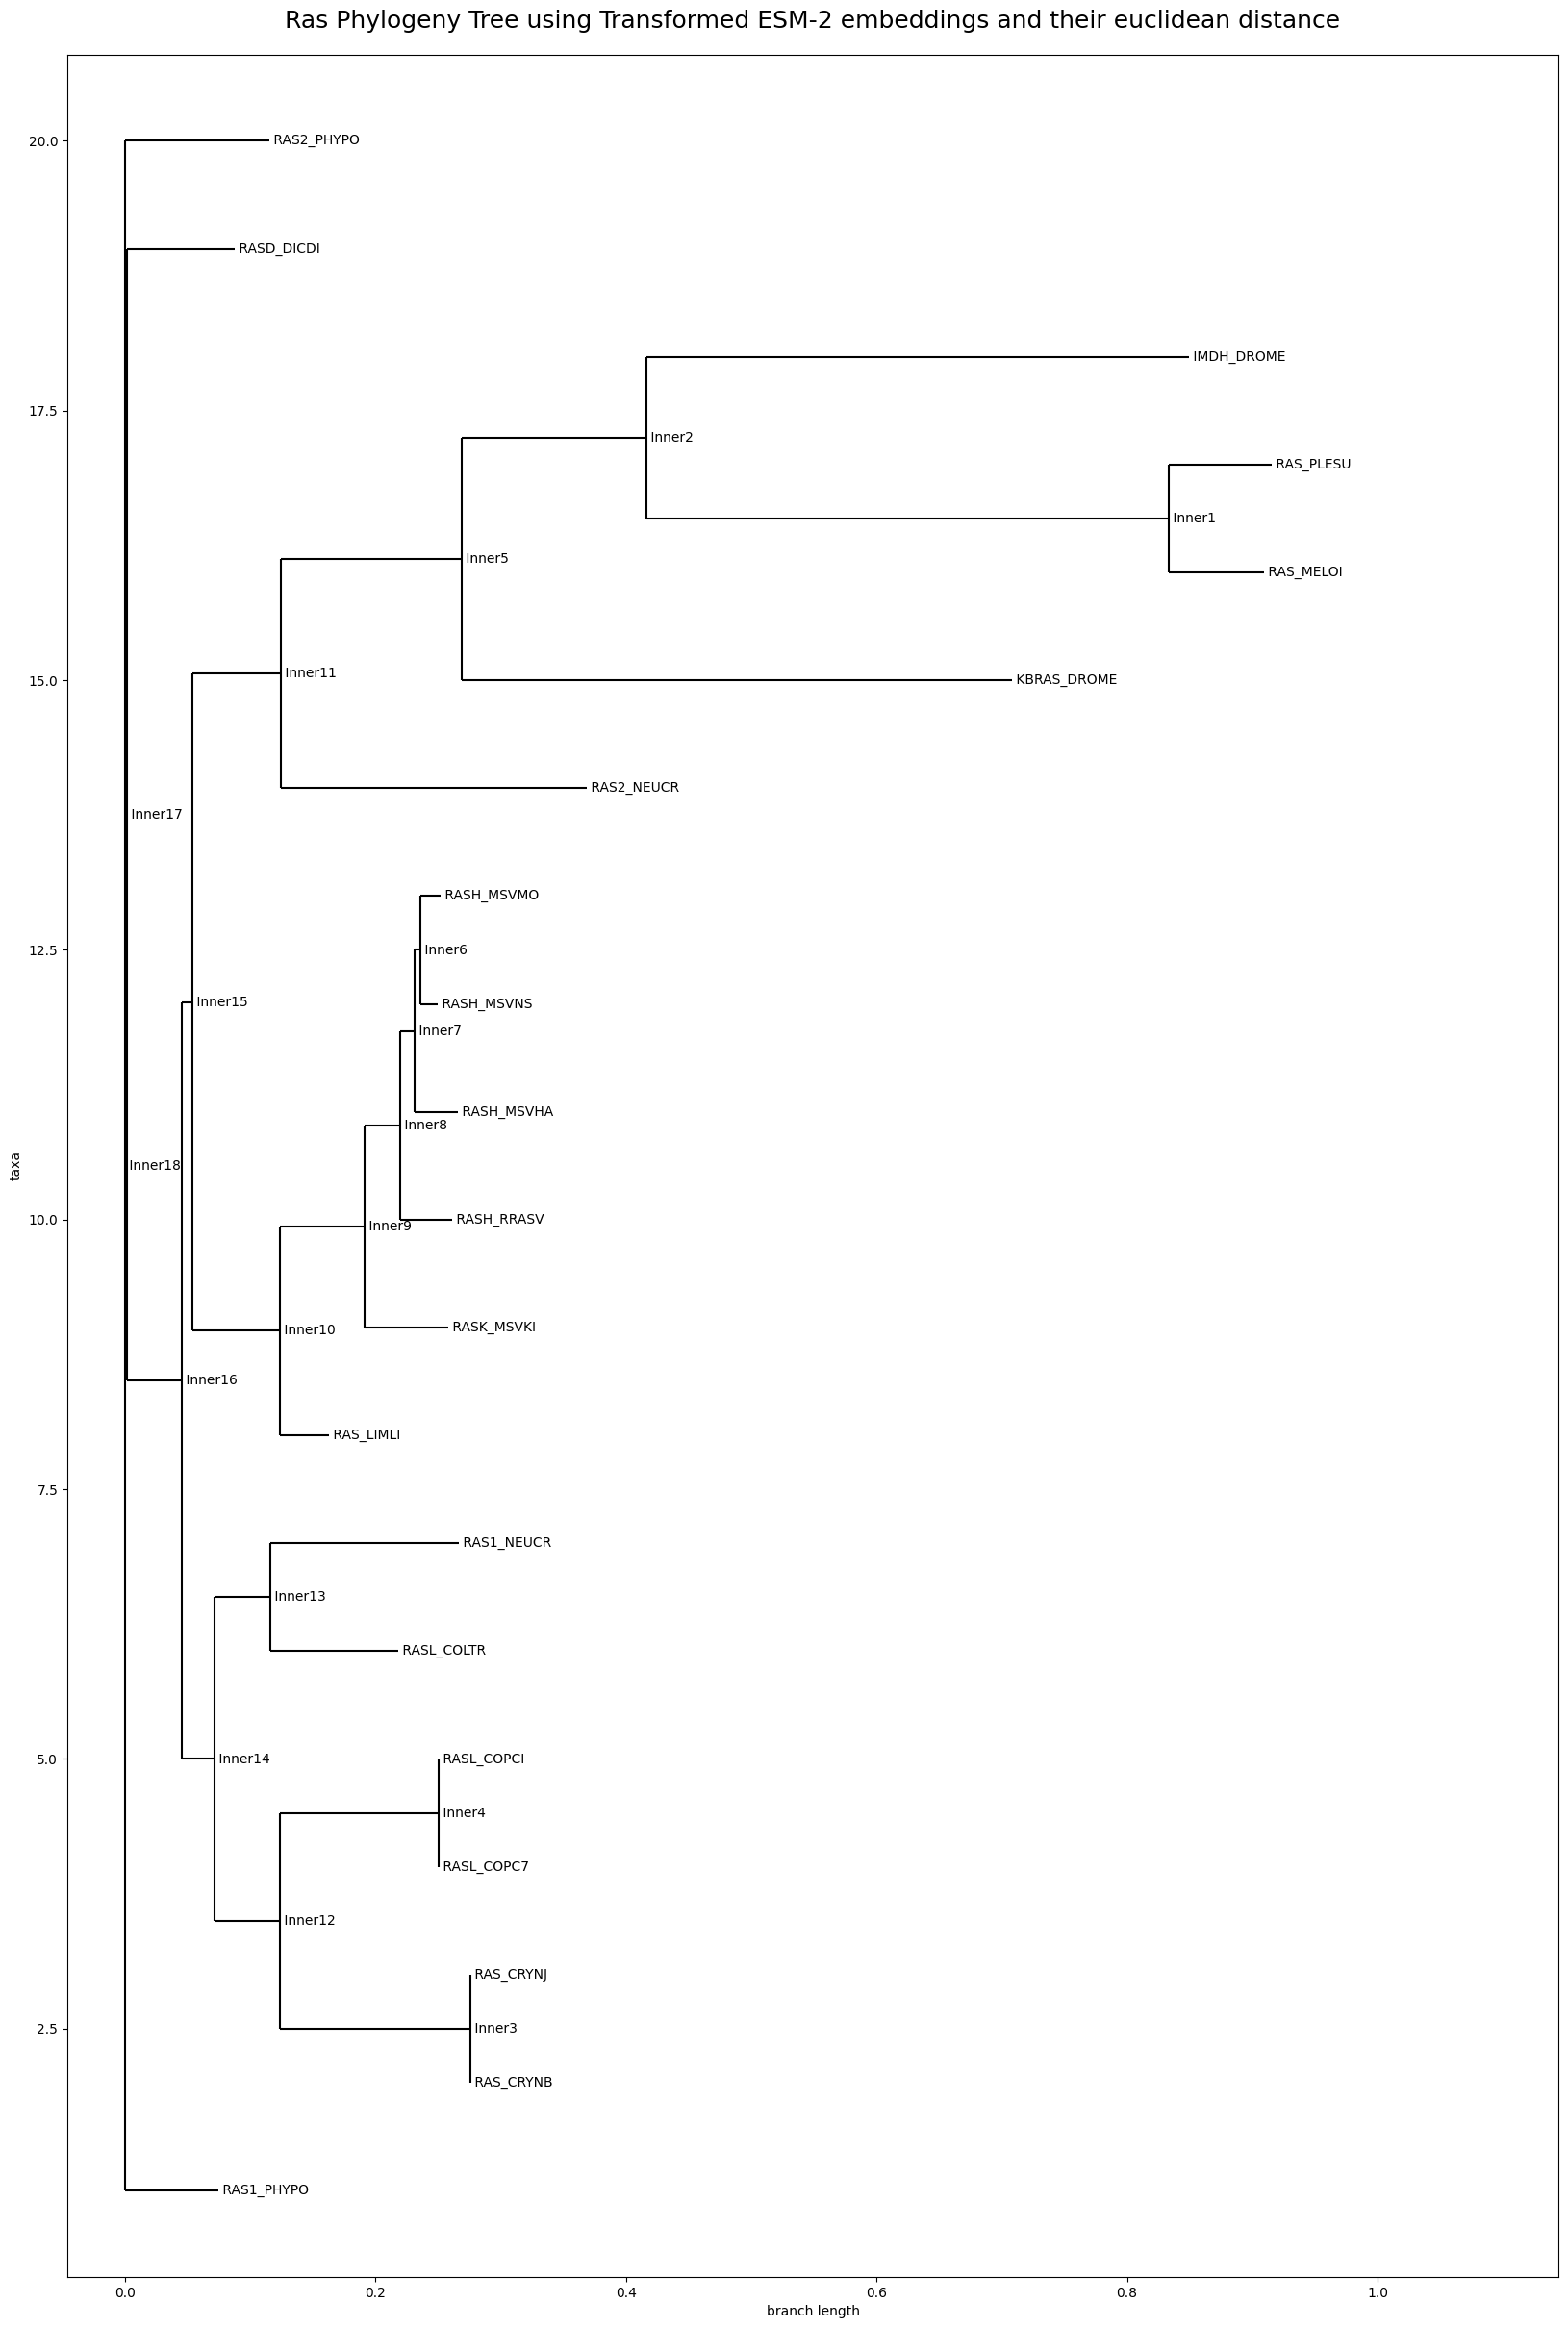

True

In [293]:
final_embeddings = model(torch_embedding)
euclidean_dist_transformed = squareform(pdist(final_embeddings.detach().numpy(), metric='euclidean'))
nj_tree_transformed = visualize_phylogeny_tree(euclidean_dist_transformed, protein_names, "Transformed ESM-2 embeddings and their euclidean distance")
compare_topology(nj_tree_clustal, nj_tree_transformed)

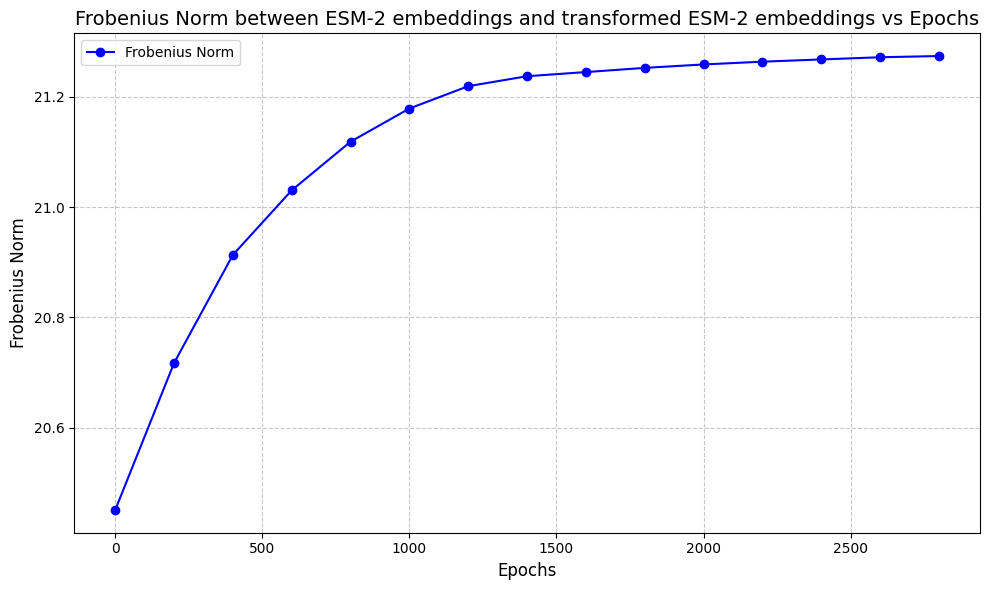

In [ ]:
epochs = np.arange(0, 2999, 200)

plt.figure(figsize=(10, 6))
plt.plot(epochs, frobenius_norm_embedding, marker='o', linestyle='-', color='b', label='Frobenius Norm')

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Frobenius Norm", fontsize=12)
plt.title("Frobenius Norm between ESM-2 embeddings and transformed ESM-2 embeddings vs Epochs", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()

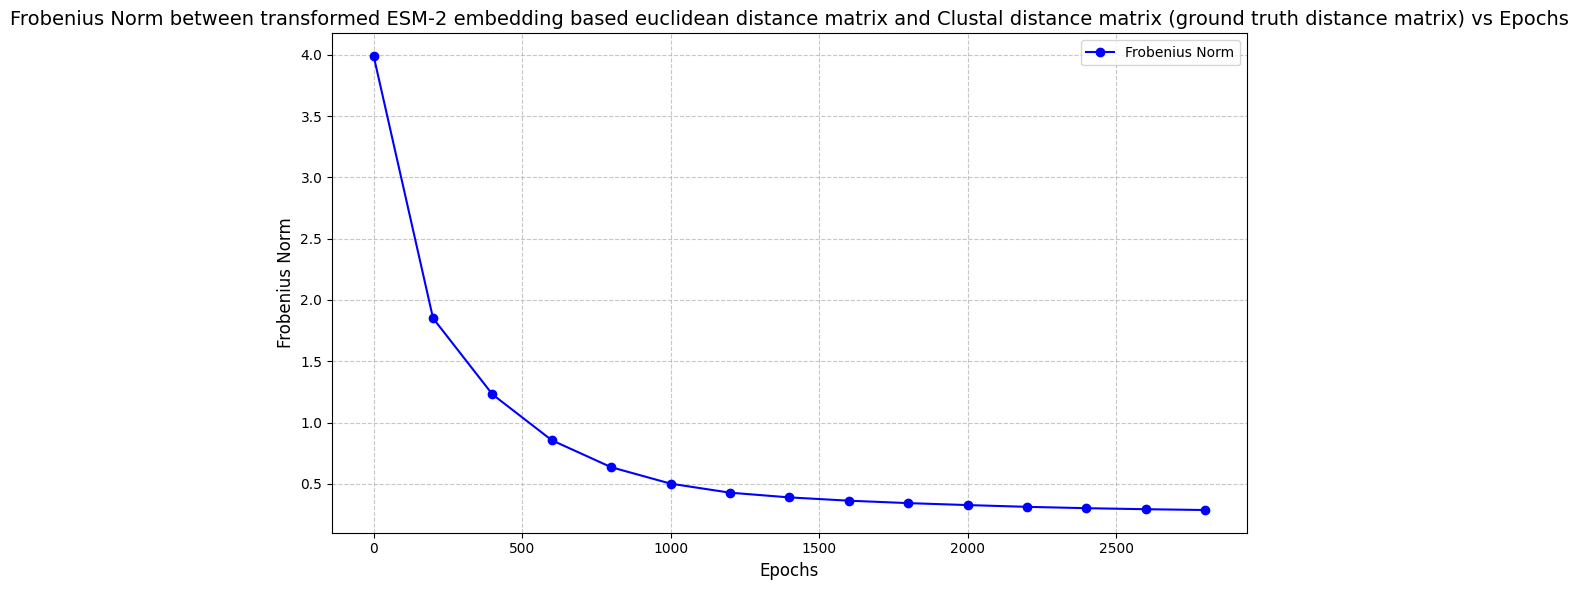

In [299]:
epochs = np.arange(0, 2999, 200)

plt.figure(figsize=(10, 6))
plt.plot(epochs, frobenius_norm_distance_matrix, marker='o', linestyle='-', color='b', label='Frobenius Norm')

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Frobenius Norm", fontsize=12)
plt.title("Frobenius Norm between transformed ESM-2 embedding based euclidean distance matrix and Clustal distance matrix (ground truth distance matrix) vs Epochs", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()